# <p id='top'>Classification using K-Nearest Neighbors</p>
We will build K-Nearest Neighbor classifier from scratch in order to understand it's working under the hood and train it to predict whether a bank customer will subscribe to a term deposit or not.

Here are the techniques we will use in this analysis:   
[1. Label encoding for the target](#le)   
[2. KNN with single feature](#of)   
[3. One-hot encoding for the categorical features](#fe)   
[4. KNN with multiple features](#mf)   
[5. Feature Scaling](#fs)   



Data: We'll use [Bank Marketing Dataset](https://archive.ics.uci.edu/dataset/222/bank+marketing). It contains data on customers of a Portuguese banking institution that ran marketing campaigns to assess whether customers would subscribe to their product. The dataset consists of 21 columns, including the target variable.

|feature|description|
|-----|-----|
|age| (numeric)|
|job| type of job (categorical: 'admin','blue collar','entrepreneur','housemaid','management','retired','self employed','services','student','technician','unemployed','unknown')|
|marital| marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)|
|education| (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')|
|default| has credit in default? (categorical: 'no','yes','unknown')|
|housing| has housing loan? (categorical: 'no','yes','unknown')|
|loan| has personal loan? (categorical: 'no','yes','unknown')|
|contact| contact communication type (categorical: 'cellular','telephone')|
|month| last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')|
|day_of_week| last contact day of the week (categorical: 'mon','tue','wed','thu','fri')|
|duration| last contact duration, in seconds (numeric).|
|campaign| number of contacts performed during this campaign and for this client (numeric, includes last contact)|
|pdays| number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)|
|previous| number of contacts performed before this campaign and for this client (numeric)|
|poutcome| outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')|
|emp.var.rate| employment variation rate - quarterly indicator (numeric)|
|cons.price.idx| consumer price index - monthly indicator (numeric)|
|cons.conf.idx| consumer confidence index - monthly indicator (numeric)|
|euribor3m| euribor 3 month rate - daily indicator (numeric)|
|nr.employed| number of employees - quarterly indicator (numeric)|
|y| has the client subscribed a term deposit? (binary: 'yes','no')|



In [1]:
import copy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns

%matplotlib inline
from PP_utils import ds_modeling, data_plotting
plt.style.use('PP_utils/deeplearning.mplstyle')

from importlib import reload
pd.set_option('display.max_columns', 10) # use display() when displaying dataframes with this option
#pd.reset_option('display.max_columns') # to reset back to default

In [2]:
# load the dataset in a dataframe
banking_df = pd.read_csv('data/subscription_prediction.csv')
display(banking_df.head())

,age,job,marital,education,default,...,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,40,admin.,married,basic.6y,no,...,93.994,-36.4,4.857,5191.0,no
1,56,services,married,high.school,no,...,93.994,-36.4,4.857,5191.0,no
2,41,blue-collar,married,unknown,unknown,...,93.994,-36.4,4.857,5191.0,no
3,57,housemaid,divorced,basic.4y,no,...,93.994,-36.4,4.857,5191.0,no
4,39,management,single,basic.9y,unknown,...,93.994,-36.4,4.857,5191.0,no


In [3]:
# number of categorical and numerical features in the df
banking_df.dtypes.value_counts()

object     11
int64       5
float64     5
Name: count, dtype: int64

In [4]:
banking_df.dtypes

age                 int64
job                object
marital            object
education          object
default            object
housing            object
loan               object
contact            object
month              object
day_of_week        object
duration            int64
campaign            int64
pdays               int64
previous            int64
poutcome           object
emp.var.rate      float64
cons.price.idx    float64
cons.conf.idx     float64
euribor3m         float64
nr.employed       float64
y                  object
dtype: object

In [5]:
banking_df.shape

(10122, 21)

We have 20 features columns, one target column and 10122 observations.

In [6]:
# number of missing values in each column
banking_df.isna().sum()

age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp.var.rate      0
cons.price.idx    0
cons.conf.idx     0
euribor3m         0
nr.employed       0
y                 0
dtype: int64

There are no missing values in this dataset.

In [7]:
banking_df['y'].value_counts()

y
no     5482
yes    4640
Name: count, dtype: int64

Number of customers who subscribed to the term deposit = 4640   
Number of customers who didn't subscribe to the term deposit = 5482

Classes are roughly balanced.

In [8]:
banking_df.describe()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,10122.000000,10122.000000,10122.000000,10122.000000,10122.000000,10122.000000,10122.000000,10122.000000,10122.000000,10122.000000
mean,40.313673,373.414049,2.369789,896.476882,0.297471,-0.432671,93.492407,-40.250573,3.035134,5138.838975
std,11.855014,353.277755,2.472392,302.175859,0.680535,1.714657,0.628615,5.271326,1.884191,85.859595
min,17.000000,0.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000
25%,31.000000,140.000000,1.000000,999.000000,0.000000,-1.800000,92.963000,-42.700000,1.252000,5076.200000
50%,38.000000,252.000000,2.000000,999.000000,0.000000,-0.100000,93.444000,-41.800000,4.076000,5191.000000
75%,48.000000,498.000000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.959000,5228.100000
max,98.000000,4199.000000,42.000000,999.000000,6.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000


#### <p id='le'>Label encoding</p>
Let's convert 'yes', 'no' to 1,0 respectively.

[Back to the top](#top)

In [9]:
banking_df['y'] = banking_df["y"].apply(lambda x: 1 if x=="yes" else 0) # banking_df['y'].replace(['yes','no'],[1,0])



In [10]:
print(banking_df['y'][10:20])

10    0
11    0
12    0
13    0
14    0
15    1
16    0
17    1
18    0
19    0
Name: y, dtype: int64


#### Train-test split
The two classes are roughly balanced so we don't require stratified test train split.

In [11]:
train_df = banking_df.sample(frac=.85,replace=False,random_state=417)
test_df = banking_df.drop(train_df.index)

print((train_df['y'].value_counts(normalize=True))*100, (test_df['y'].value_counts(normalize=True))*100, sep='\n')

y
0    54.009763
1    45.990237
Name: proportion, dtype: float64
y
0    55.006588
1    44.993412
Name: proportion, dtype: float64


In [12]:
X_train = train_df.drop(columns=['y'])
y_train = train_df['y']

X_test = test_df.drop(columns=['y'])
y_test = test_df['y']

#### <p id='of'>KNN for one feature</p>

Now that we have our training and test sets, we can implement our algorithm. Before we begin, we need to select a distance metric to calculate the distance between observations. We will use Euclidean distance.

[Back to the top](#top)

In [13]:
def knn(single_test_input,feature, k):
    X_train['distance'] = np.abs(X_train[feature] - single_test_input[feature])
    idx_k_smallest = X_train['distance'].nsmallest(k).index
    prediction = y_train[idx_k_smallest].mode()[0]
    return prediction


In [14]:
feature = 'age'
k=3
single_test_input=X_test.iloc[108]
model_prediction =knn(single_test_input,feature,k)
actual_label = y_test.iloc[108]
print(model_prediction,actual_label,sep='\n')

0
0


In [15]:
# Evaluatin the model
X_test['age_predicted_y'] = X_test.apply(lambda row: knn(row,feature='age', k=3), axis=1)
# X_test['age_predicted_y'] = X_test.apply(knn, args=('age', 3), axis=1)   
correct_predictions = (X_test['age_predicted_y'] == y_test)
accuracy = correct_predictions.mean()
print(accuracy)



0.538866930171278


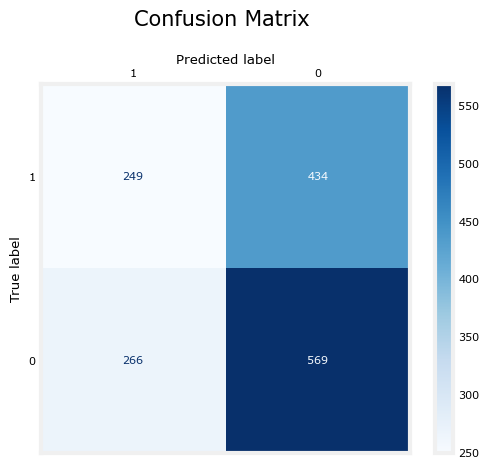

              precision    recall  f1-score   support

           1       0.57      0.68      0.62       835
           0       0.48      0.36      0.42       683

    accuracy                           0.54      1518
   macro avg       0.53      0.52      0.52      1518
weighted avg       0.53      0.54      0.53      1518



In [16]:
data_plotting.clf_confusion_matrix(y_test,X_test['age_predicted_y'], classes=[1,0])

In [17]:
X_test['campaign_predicted_y'] = X_test.apply(lambda row: knn(row,feature='campaign',k=3),axis=1)

model_accuracy = (X_test['campaign_predicted_y'] == y_test).mean() * 100
print(model_accuracy)

55.13833992094862


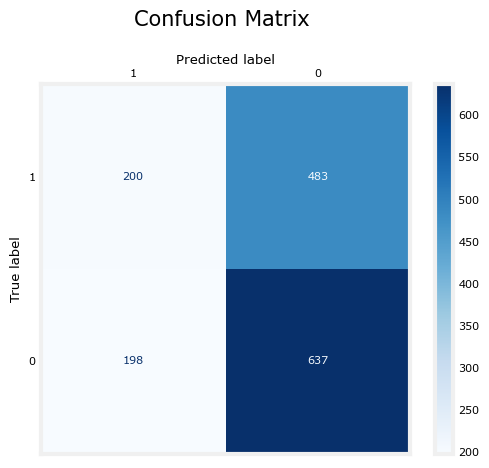

              precision    recall  f1-score   support

           1       0.57      0.76      0.65       835
           0       0.50      0.29      0.37       683

    accuracy                           0.55      1518
   macro avg       0.54      0.53      0.51      1518
weighted avg       0.54      0.55      0.52      1518



In [18]:
data_plotting.clf_confusion_matrix(y_test,X_test['campaign_predicted_y'], classes=[1,0])

We have only used 'age' feature for this model and it seems like accuracy is poor overall and increasing the number of neighbors is only slighly moving the accuracy but not enough to be significant. As a next step we should use more features for the model.

#### <p id='fe'> Feature Engineering (One-hot encoding)</p>
Fortunately, we don't have to rely on using just one feature at a time. We can use multiple at the same time, which might improve our model's performance. There are several categorical variables in our data set as well. We can't calculate the distance between two strings. That's another limitation of the k-nearest neighbor algorithm. We can work around it without much effort.

Just like we encoded the yes and no values as 0 and 1 for our target variable, we can encode our categorical features.

The practice of dropping the first category in one-hot encoding is a common convention, particularly for linear models, to avoid perfect multicollinearity, as the sum of all one-hot encoded columns for a categorical variable equals one, creating a linear dependency.
The drop='first' parameter in tools like OneHotEncoder or pd.get_dummies is designed to remove one category per feature, thereby reducing redundancy and simplifying the model.
This can improve model interpretability and performance, especially in models like linear regression that are sensitive to multicollinearity.

Dropping the first category in one-hot encoding has minimal impact on the K-Nearest Neighbors (KNN) algorithm, as KNN relies on distance metrics between feature vectors and does not suffer from multicollinearity like linear models. While dropping the first category reduces dimensionality slightly—potentially improving efficiency and mitigating the curse of dimensionality—it generally does not affect model performance significantly because the information remains intact in the relative distances between samples.

In practice, for KNN, keeping all categories is often safer and more interpretable, especially since the algorithm is robust to redundant features. If dimensionality becomes an issue, techniques like PCA or feature selection are preferred over arbitrary column dropping.

[Back to the top](#top)

In [19]:
# create a copy of the dataframe before one-hot encoding
banking_df_copy = copy.deepcopy(banking_df)

In [20]:
banking_df_copy['marital'].value_counts()

marital
married     5864
single      3152
divorced    1082
unknown       24
Name: count, dtype: int64

We can use pd.getdummies() function to get the same result but in one step. 

In [21]:
banking_df_copy = pd.get_dummies(data=banking_df_copy,columns=['marital'],drop_first=True)
print(banking_df_copy.columns)
banking_df_copy.head()


Index(['age', 'job', 'education', 'default', 'housing', 'loan', 'contact',
       'month', 'day_of_week', 'duration', 'campaign', 'pdays', 'previous',
       'poutcome', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx',
       'euribor3m', 'nr.employed', 'y', 'marital_married', 'marital_single',
       'marital_unknown'],
      dtype='object')


,age,job,education,default,housing,...,nr.employed,y,marital_married,marital_single,marital_unknown
0,40,admin.,basic.6y,no,no,...,5191.0,0,True,False,False
1,56,services,high.school,no,no,...,5191.0,0,True,False,False
2,41,blue-collar,unknown,unknown,no,...,5191.0,0,True,False,False
3,57,housemaid,basic.4y,no,yes,...,5191.0,0,False,False,False
4,39,management,basic.9y,unknown,no,...,5191.0,0,False,True,False


#### <p id='mf'>KNN with multiple features</p>

We'll now implement the k-nearest neighbor algorithm for multiple features using the encoded data above.    
features = ["age", "campaign", "marital_married", "marital_single"]

[Back to the top](#top)

In [22]:
# let's create train test split using the df where we encoded the marital column
train_df = banking_df_copy.sample(frac=0.85, random_state=417)
test_df = banking_df_copy.drop(train_df.index)

X_train = train_df.drop("y", axis=1)
y_train = train_df["y"]

X_test = test_df.drop("y", axis=1)
y_test = test_df["y"]

In [23]:
y_train.value_counts(normalize=True), y_test.value_counts(normalize=True)

(y
 0    0.540098
 1    0.459902
 Name: proportion, dtype: float64,
 y
 0    0.550066
 1    0.449934
 Name: proportion, dtype: float64)

In [24]:
def knn(single_test_input,features,k):
    squared_distance = (X_train[features].subtract(single_test_input[features], axis=1))**2
    X_train['distance'] = (squared_distance.sum(axis=1))**0.5
    idx_smallest = X_train['distance'].astype('float').nsmallest(n=k).index
    prediction = y_train[idx_smallest].mode()[0]
    return prediction

In [25]:
features = ["age", "campaign", "marital_married", "marital_single"]
#print(X_train[features].dtypes)
#single_test_input = X_test.iloc[108]
k=3
# model_prediction = knn(single_test_input,features,k)
# print(model_prediction, y_test.iloc[108])
X_test['predicted_y'] = X_test.apply(lambda row: knn(row, features, k),axis=1)
model_accuracy = (X_test['predicted_y']==y_test).mean() * 100
print(model_accuracy)

55.467720685111985


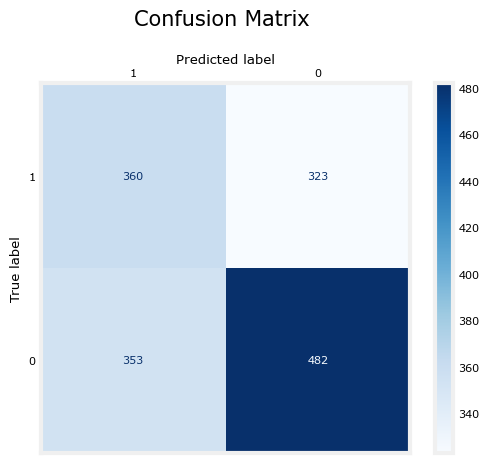

              precision    recall  f1-score   support

           1       0.60      0.58      0.59       835
           0       0.50      0.53      0.52       683

    accuracy                           0.55      1518
   macro avg       0.55      0.55      0.55      1518
weighted avg       0.56      0.55      0.56      1518



In [26]:
data_plotting.clf_confusion_matrix(y_test,X_test['predicted_y'], classes=[1,0])

Accuracy remains poor even with 4 features. This is likely due to very different range of values of the features we used. So let's try feature scaling to overcome this.

#### <p id='fs'> Feature Scaling</p>
We'll normalize our age and campaign features using the min and max values from our training data and implement the algorithm using the same features as before.
Even with normalization, our model might not show a significant improvement. However, this standard practice of scaling ensures that our model's performance remains consistent across both training and test sets.

[Back to the top](#top)

In [27]:
min_age = X_train['age'].min()
max_age = X_train['age'].max()
X_train['age'] = (X_train['age'] -min_age )/(max_age - min_age)
X_test['age'] = (X_test['age'] -min_age )/(max_age - min_age)

min_cam = X_train['campaign'].min()
max_cam = X_train['campaign'].max()
X_train['campaign'] = (X_train['campaign'] - min_cam)/(max_cam - min_cam)
X_test['campaign'] = (X_test['campaign'] - min_cam)/(max_cam - min_cam)

In [28]:
eatures = ["age", "campaign", "marital_married", "marital_single"]
k=3

X_test['predicted_y'] = X_test.apply(lambda row: knn(row, features, k),axis=1)
model_accuracy = (X_test['predicted_y']==y_test).mean() * 100
print(model_accuracy)

55.13833992094862


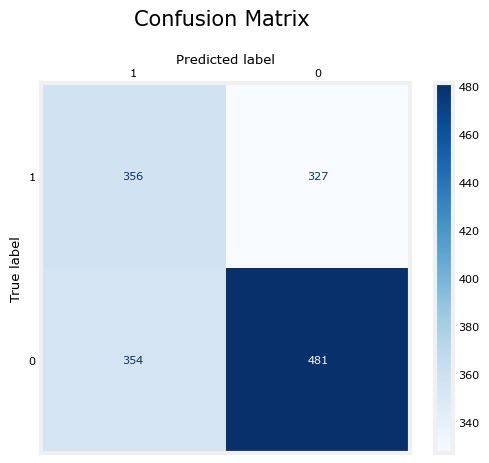

              precision    recall  f1-score   support

           1       0.60      0.58      0.59       835
           0       0.50      0.52      0.51       683

    accuracy                           0.55      1518
   macro avg       0.55      0.55      0.55      1518
weighted avg       0.55      0.55      0.55      1518



In [29]:
data_plotting.clf_confusion_matrix(y_test,X_test['predicted_y'], classes=[1,0])

## Conclusion

There is not much improvement in accuracy even after feature scaling. As we suspected, our model's performance didn't improve very much. If we were to randomly guess a particular data point's class, we would be correct 50% of the time since there are only two classes. So our model is only performing slightly better than a random guess right now. We need a better method for selecting features than random choice. We will explore this more in the next notebook.